# UFO Reports EDA

# Table of Contents
* [1. Introduction](#1)
    * [1.1 Imports and Load Data](#1.1)
* [2 Basic Exploration and Data Cleaning](#2)
    * [2.1 Basic Exploration](#2.1)
    * [2.2 Data Cleaning](#2.2)
* [3 EDA](#3)

# 1. Introduction
<a class="anchor" id="1"></a>

#### This data was scraped from the https://nuforc.org/ web database and is current as of 1/13/23
#### This entire dataset contains over 120,000 UFO reports

## 1.1 Imports and Loading Data
<a class="anchor" id="1.1"></a>

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import folium
import re
import seaborn as sns
from datetime import timedelta

pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_rows", None)

C:\Users\ckjar\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# # Load data
df = pd.read_csv("C:\\Users\\ckjar\\Documents\\_Projects\\Ufo Analysis\\ufo_data.csv", sep=';')

# 2. Basic Exploration and Data Cleaning
<a class="anchor" id="2"></a>

## 2.1 Basic Exploration
<a class="anchor" id="2.1"></a>

In [89]:
df.shape

(120525, 12)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142333 entries, 0 to 142332
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Date / Time  142232 non-null  object
 1   City         141855 non-null  object
 2   State        132659 non-null  object
 3   Country      141997 non-null  object
 4   Shape        135973 non-null  object
 5   Duration     135330 non-null  object
 6   Summary      142260 non-null  object
 7   Posted       142330 non-null  object
 8   Images       1705 non-null    object
dtypes: object(9)
memory usage: 9.8+ MB


In [4]:
df.isnull().sum()

Date / Time       101
City              478
State            9674
Country           336
Shape            6360
Duration         7003
Summary            73
Posted              3
Images         140628
dtype: int64

## 2.2 Data Cleaning
<a class="anchor" id="2.2"></a>

#### Todo:
- ~~Fix some state name abbrv~~
- ~~Drop entries that are not in a list of the 50 US states~~
- ~~Drop url feature~~
- ~~Drop posted date~~
- ~~Convert occurred_date_time to pandas datetime~~
- ~~Better group shape column~~
- Clean duration column (lots of different format)

In [5]:
df = df.rename(columns={'Date / Time': 'datetime'})

In [9]:
df = df[df.Country == 'USA']

In [7]:
df['State'] = df['State'].str.replace('Fl', 'FL')
df['State'] = df['State'].str.replace('Ca', 'CA')
df['State'] = df['State'].str.replace('NB', 'NE')
df['State'] = df['State'].str.replace('M0', 'MO')
df['State'] = df['State'].str.replace('Washington, DC', 'DC')
df['State'] = df['State'].str.replace('South CArolina  ', 'SC')

In [10]:
# create list of US states
states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
# convert states column to uppercase
df['State'] = df['State'].str.upper()
# set df to df is state is in states list
df = df[df.State.isin(states)]

In [11]:
# drop posted date and url
df = df.drop(['Posted', 'Images'], axis=1)

In [12]:
# # convert occurred date time to pandas datetime object
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df.loc[df['datetime'].dt.year >= 2023, 'datetime'] -= pd.DateOffset(years=100)
df = df.dropna(subset=['datetime'])

In [13]:
df['Date'] = df.datetime.dt.date
df['Day'] = df.datetime.dt.day
df['Month'] = df.datetime.dt.month
df['Year'] = df.datetime.dt.year
df['Time'] = df.datetime.dt.hour

In [14]:
df.head()

,datetime,City,State,Country,Shape,Duration,Summary,Date,Day,Month,Year,Time
1,2022-12-22 09:29:00,Newark,DE,USA,Light,30 secomds,I saw a light that was not flashing moving then disappeared,2022-12-22,22,12,2022,9
3,2022-12-21 21:33:00,Columbus,OH,USA,Light,1-2 minutes,4-5 orange balls of light in a straight line,2022-12-21,21,12,2022,21
6,2022-12-21 04:11:00,Franklin,ME,USA,Light,2 hours,Hovering bright light with satellite lights expelling from it,2022-12-21,21,12,2022,4
7,2022-12-20 23:30:00,East Greenwich,RI,USA,Light,3 seconds maybe even less,I was driving the interstate at night with my buddy headed to casino when a very bright flashing light appeared in the horizon,2022-12-20,20,12,2022,23
8,2022-12-20 21:58:00,Mentor Headlands,OH,USA,Cylinder,A few minutes,"Looked cylindrical from the lights, changing colors from white to red to orange then yellow back to white, .",2022-12-20,20,12,2022,21


In [15]:
# capitalize shape column, causing some some groups to combine, EX: circle merged with Circle
df['Shape'] = df['Shape'].str.capitalize()
# Replace some different variations of the same shape
df['Shape'] = df['Shape'].replace({'Triangular':'Triangle',
                                   'Changed':'Changing',
                                   'Round':'Circle',
                                   'Delta':'Triangle',
                                   'Unknown': 'Other'})
# Drop a few shapes with only 2 occurances
df = df[df['Shape'].map(df['Shape'].value_counts()) >= 3]

In [16]:
df.head()

,datetime,City,State,Country,Shape,Duration,Summary,Date,Day,Month,Year,Time
1,2022-12-22 09:29:00,Newark,DE,USA,Light,30 secomds,I saw a light that was not flashing moving then disappeared,2022-12-22,22,12,2022,9
3,2022-12-21 21:33:00,Columbus,OH,USA,Light,1-2 minutes,4-5 orange balls of light in a straight line,2022-12-21,21,12,2022,21
6,2022-12-21 04:11:00,Franklin,ME,USA,Light,2 hours,Hovering bright light with satellite lights expelling from it,2022-12-21,21,12,2022,4
7,2022-12-20 23:30:00,East Greenwich,RI,USA,Light,3 seconds maybe even less,I was driving the interstate at night with my buddy headed to casino when a very bright flashing light appeared in the horizon,2022-12-20,20,12,2022,23
8,2022-12-20 21:58:00,Mentor Headlands,OH,USA,Cylinder,A few minutes,"Looked cylindrical from the lights, changing colors from white to red to orange then yellow back to white, .",2022-12-20,20,12,2022,21


# 3. EDA
<a class="anchor" id="3"></a>

<AxesSubplot:title={'center':'Number of Sightings Each Year'}, xlabel='Year', ylabel='count'>

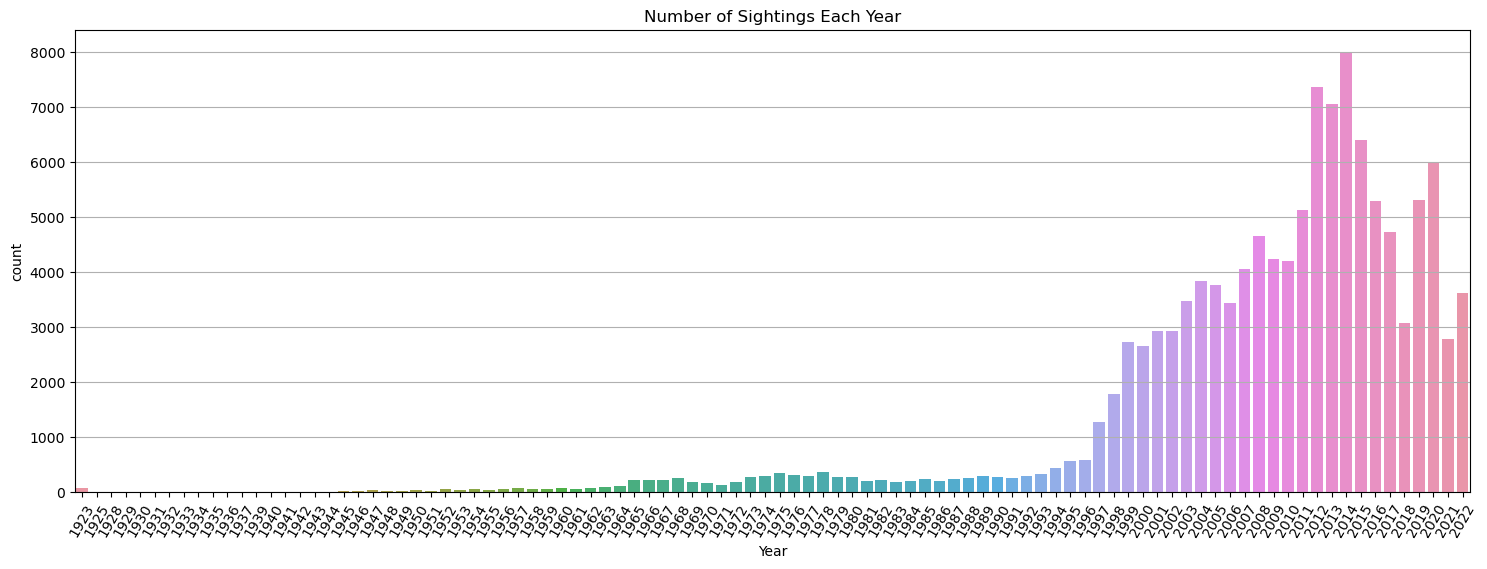

In [20]:
plt.figure(figsize=(18,6))
plt.title("Number of Sightings Each Year")
plt.xticks(rotation=60)
plt.grid()
sns.countplot(x=df['Year'])

<AxesSubplot:title={'center':'Number of Sightings of Each UFO Shape'}, xlabel='Shape', ylabel='count'>

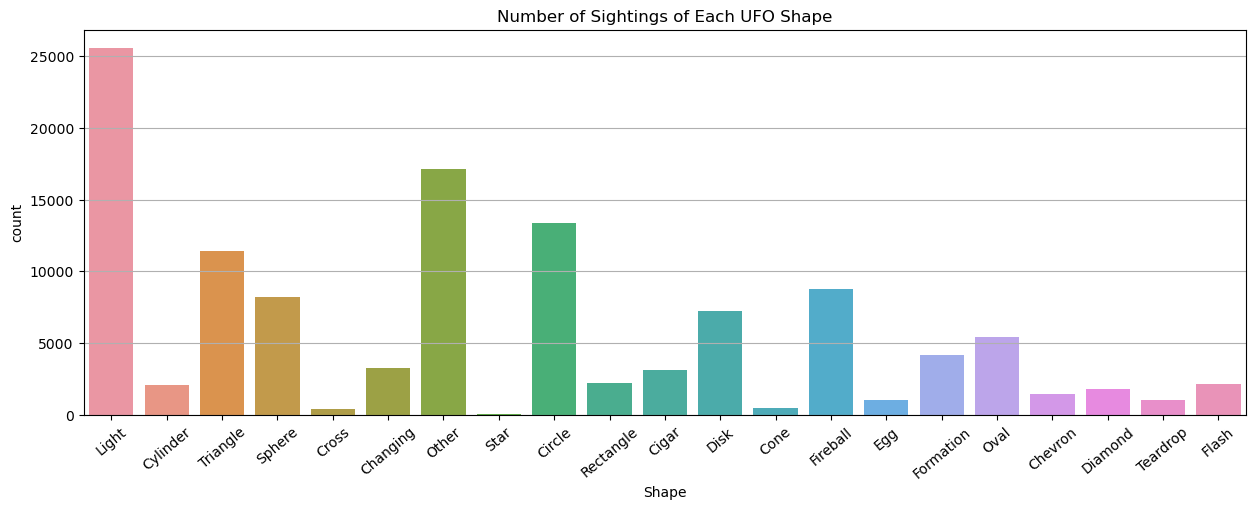

In [285]:
plt.figure(figsize=(15,5))
plt.title("Number of Sightings of Each UFO Shape")
plt.xticks(rotation=40)
plt.grid()
sns.countplot(x='Shape', data=df)

#### UFO's are most frequently described as 'lights' or 'circles'

<AxesSubplot:title={'center':'Number of UFO Sightings by State'}, xlabel='State', ylabel='count'>

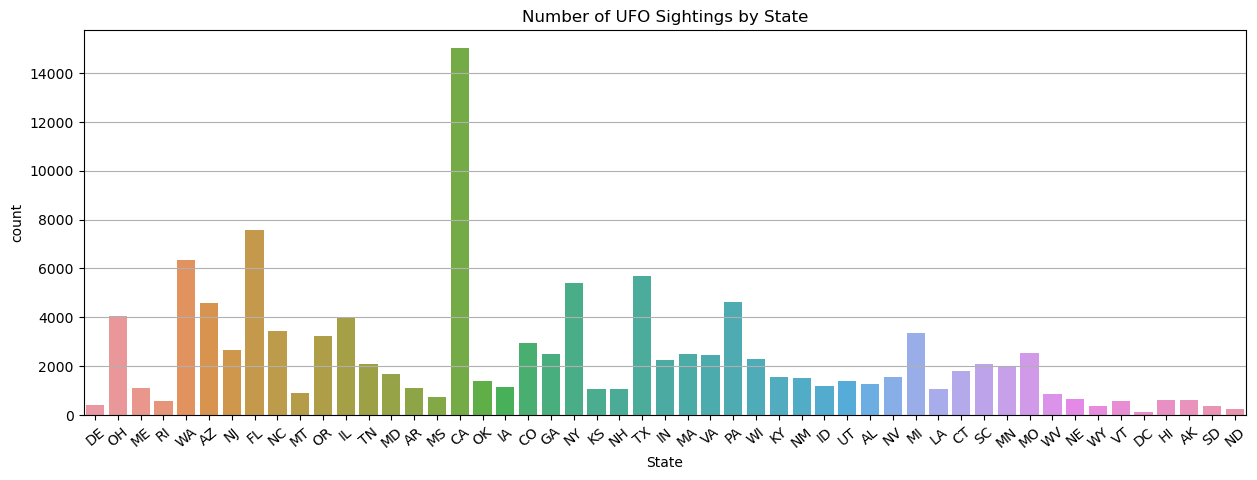

In [25]:
plt.figure(figsize=(15,5))
plt.title("Number of UFO Sightings by State")
plt.xticks(rotation=40)
plt.grid()
sns.countplot(x='State', data=df)

### California has the most reported UFO sightings represented in this database with around 15,000 sightings. California is far ahead with Texas having the second most reports at just under 6,000

<AxesSubplot:title={'center':'Top 10 Cities with the Most Sightings'}>

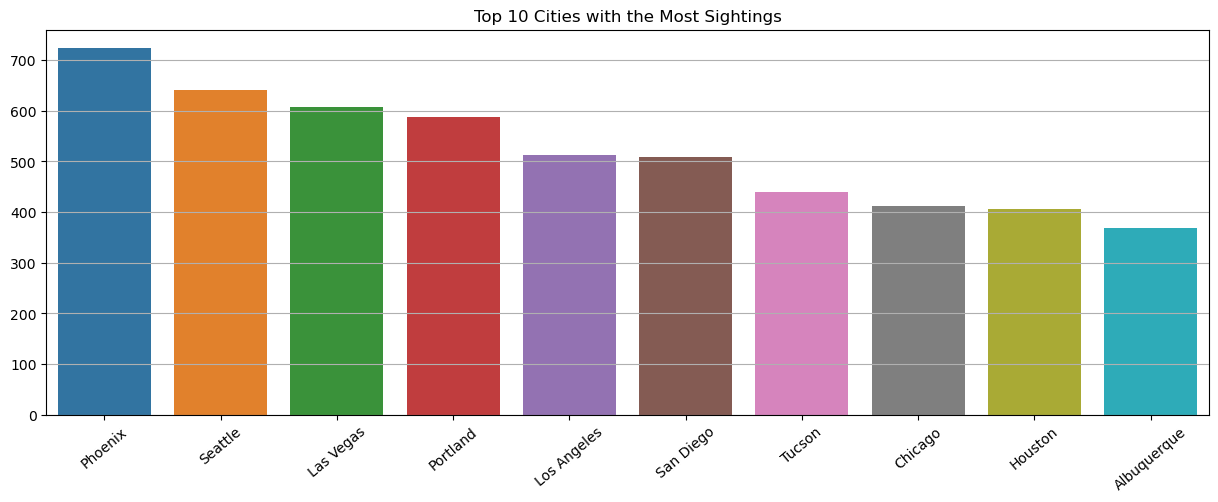

In [55]:
topcities = df.City.value_counts()[0:10]

plt.figure(figsize=(15,5))
plt.title("Top 10 Cities with the Most Sightings")
plt.xticks(rotation=40)
plt.grid()
sns.barplot(x=topcities.index, y=topcities.values)

#### Phoenix, AZ has the most UFO reports, with just over 700, followed by Seattle with around 650 reports

<AxesSubplot:title={'center':'Number of Sightings by Day of the Week'}, xlabel='datetime', ylabel='count'>

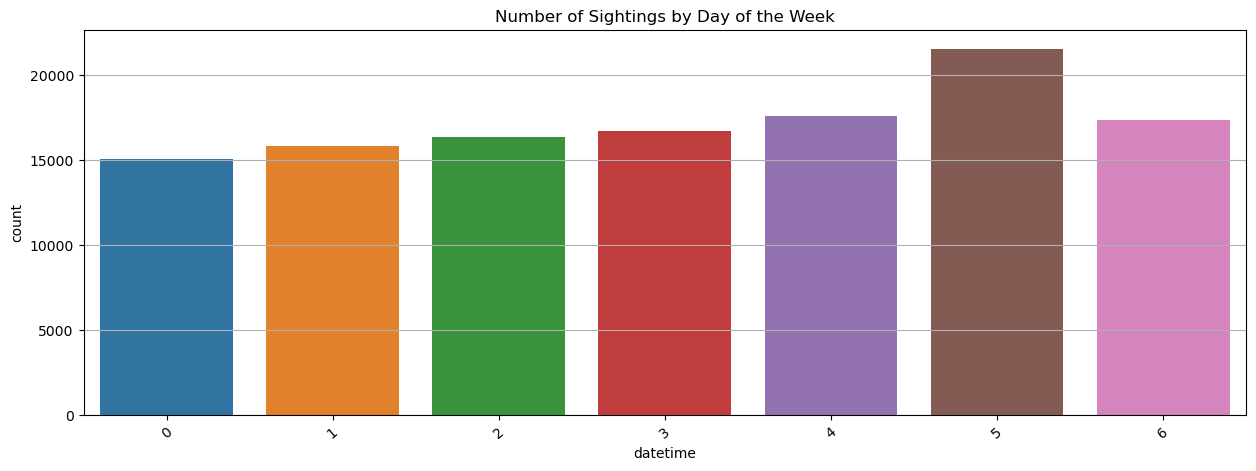

In [75]:
plt.figure(figsize=(15,5))
plt.title("Number of Sightings by Day of the Week")
plt.xticks(rotation=40)
plt.grid()

sns.countplot(x=df['datetime'].dt.dayofweek)

#### There are more sightings on Saturdays than any other day of the week

<AxesSubplot:title={'center':'Number of Sightings by Time of Day'}, xlabel='Time', ylabel='count'>

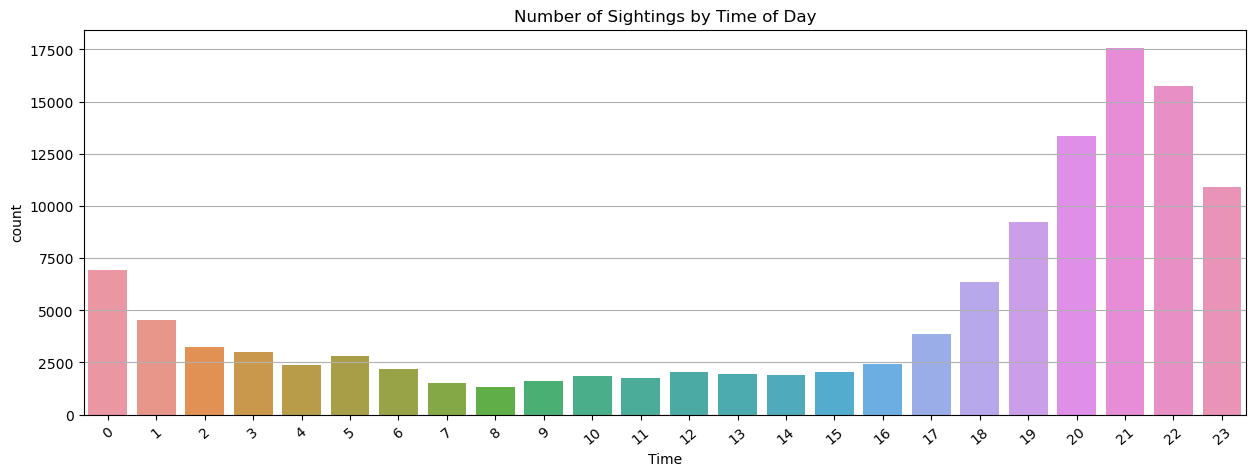

In [76]:
plt.figure(figsize=(15,5))
plt.title("Number of Sightings by Time of Day")
plt.xticks(rotation=40)
plt.grid()
sns.countplot(x=df['Time'])

#### Unsurprisingly, sightings peak at night, picking up around 8pm - midnight

<AxesSubplot:title={'center':'Number of Sightings Each Day of the Month'}, xlabel='Day', ylabel='count'>

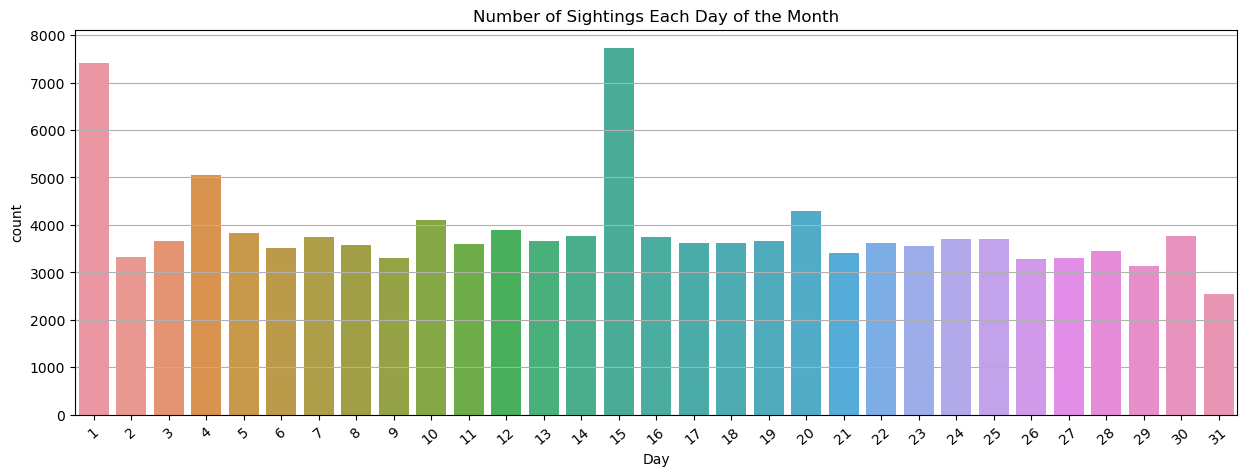

In [79]:
plt.figure(figsize=(15,5))
plt.title("Number of Sightings Each Day of the Month")
plt.xticks(rotation=40)
plt.grid()
sns.countplot(x='Day', data=df)

#### Most sightings tend to occur on the 1st of the month or right in the middle, on the 15th.

<AxesSubplot:title={'center':'Number of Sightings Each Month'}, xlabel='Month', ylabel='count'>

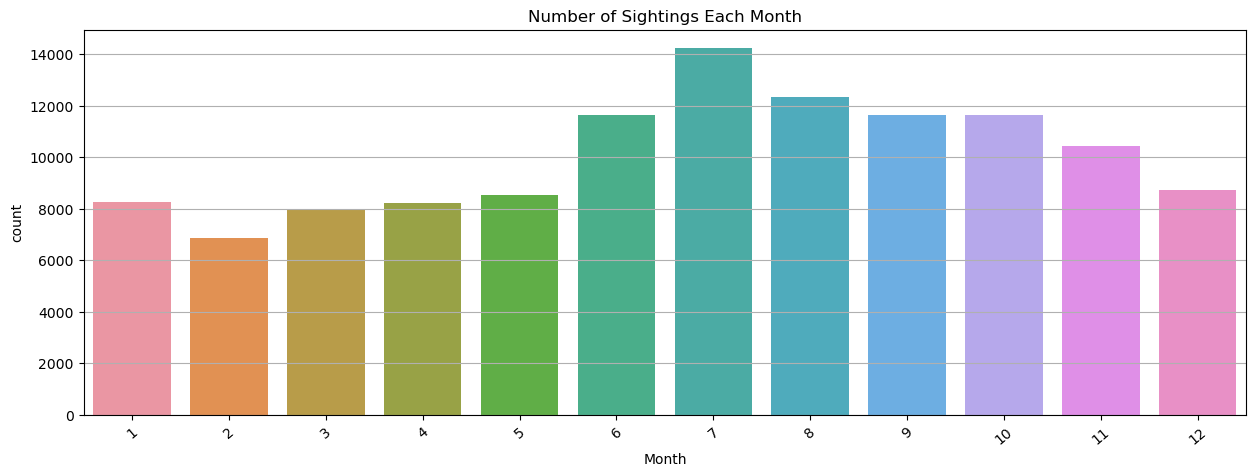

In [378]:
plt.figure(figsize=(15,5))
plt.title("Number of Sightings Each Month")
plt.xbticks(rotation=40)
plt.grid()
sns.countplot(x=df['Month'])

#### The above figure shows the total number of UFO sightings in each month. Seeing that July had the most, I wondered if this was just even distribution, or was there more to this

<AxesSubplot:title={'center':'Number of Sightings Each Day in July'}, xlabel='Day', ylabel='count'>

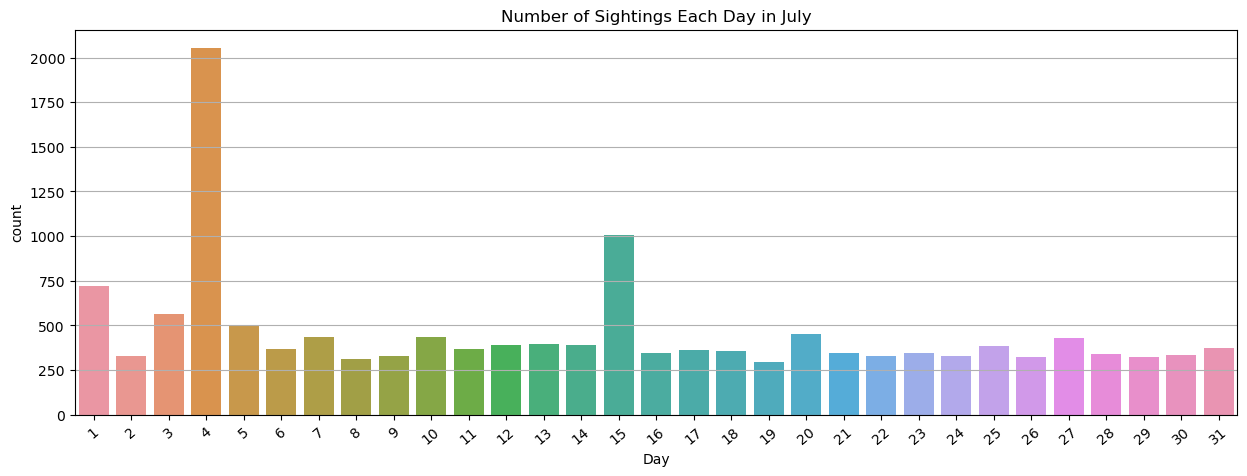

In [379]:
julySightings = df.loc[df['datetime'].dt.month == 7]

plt.figure(figsize=(15,5))
plt.title("Number of Sightings Each Day in July")
plt.xticks(rotation=40)
plt.grid()
sns.countplot(x=julySightings['Day'])

#### This is the number of sightings on each day in July. Quite a coincidence that the day with the most UFO sightings in the US is the 4th of July.

### Next, I decided to see if there were any reports that corroborated each other. To do this, I filtered the data where there were reports in the same city of the  same state (since there can be cities with the same name in different states) and also witnessed on the same date

In [290]:
multipleSightings = df[df.duplicated(['Date','City','State'], keep=False)]

In [291]:
len(multipleSightings)

7468

#### As you can see, there are almost 7,500 reports that met the above criteria. Next, I wanted to see some of these reports with multiple witnesses. I also decided to filter this by State or City, so the result will be searchable to find sightings in your location

In [381]:
state = multipleSightings.loc[df['State'] == 'MO'] 
search = state[state.duplicated(['Date','City'], keep=False)]
result = search
result = result.sort_values(by=['City', 'Date'])
print(len(result))
result

# city = multipleSightings.loc[df['City'] == 'St. Louis'] 
# search = city[city.duplicated(['Date'], keep=False)]
# result = search
# result = result.sort_values(by=['Date'])
# print(len(result))
# result

148


,datetime,City,State,Country,Shape,Duration,Summary,Date,Day,Month,Year,Time
116246,2001-10-04 22:00:00,Ashgrove,MO,USA,Light,1,MISSOURI INVESTIGATORS GROUP Report: Investigated ufo reports by witness(es) in Ash Grove from 11/17/99 to 10/4/01,2001-10-04,4,10,2001,22:00:00
116247,2001-10-04 21:03:00,Ashgrove,MO,USA,Diamond,14 minutes,Dimand shaped craft,2001-10-04,4,10,2001,21:03:00
65056,2012-06-24 02:30:00,Ballwin,MO,USA,Light,1-2 minutes,"Saw three orange colored fireball type lights to the east forming somewhat of triangle, 2 stayed east 1 went up to NW direction",2012-06-24,24,6,2012,02:30:00
65060,2012-06-24 00:50:00,Ballwin,MO,USA,Circle,5-10 minutes,"At about 1:00am CDT on June 24th 2012 in Ballwin, Missouri myself and one other witness spotted 4-5 what appeared to be glowing/flaming",2012-06-24,24,6,2012,00:50:00
36975,2015-11-22 05:30:00,Ballwin,MO,USA,Other,1:00/5:30present,Only 1 out there as of 5:30 cen. Time. ((NUFORC Note: Venus? PD)),2015-11-22,22,11,2015,05:30:00
36977,2015-11-22 04:30:00,Ballwin,MO,USA,Triangle,1:00/4:30present,"Star-shaped, bright red tips, green wings, maybe and glistening center. ((NUFORC Note: Venus? PD))",2015-11-22,22,11,2015,04:30:00
52751,2013-12-10 20:00:00,Belton,MO,USA,Sphere,2-4 minutes,"Bright orange, steadily-glowing ball of light (Sphere) moving across the sky with sudden disappear/reappear before moving on.",2013-12-10,10,12,2013,20:00:00
52752,2013-12-10 20:00:00,Belton,MO,USA,Light,3 minutes,Bright orange lights hovered then disappeared.,2013-12-10,10,12,2013,20:00:00
102747,2004-12-13 20:15:00,Blue Springs,MO,USA,Oval,20 sec,Blacked out craft (2) headed south crossing in controlled airspace in Blue Springs area.,2004-12-13,13,12,2004,20:15:00
102748,2004-12-13 20:15:00,Blue Springs,MO,USA,Disk,20 seconds,"Two unidentified objects flying in left echelon formation over Kansas City, Missouri",2004-12-13,13,12,2004,20:15:00


#### As shown in the dataframe above, there are 148 UFO reports in Missouri that have corroborated reports. 
##### For example, the first 2 rows show there were 2 sightings in Ashgrove, MO on 10/4/2001. The next two are unrelated to those, but both took place in Ballwin on 6/24/2012.